**Table of contents**<a id='toc0_'></a>    
- 1. [Giới thiệu về hướng triển khai](#toc1_)    
- 2. [Hàm tiện ích](#toc2_)    
  - 2.1. [Hàm pipelines xử lý dữ liệu](#toc2_1_)    
    - 2.1.1. [Thao tác file](#toc2_1_1_)    
    - 2.1.2. [Tạo đặc trưng](#toc2_1_2_)    
  - 2.2. [Một số utils khác](#toc2_2_)    
  - 2.3. [Data Augmentation](#toc2_3_)    
- 3. [Xử lý data](#toc3_)    
  - 3.1. [Tạo features](#toc3_1_)    
  - 3.2. [Chia train-test](#toc3_2_)    
  - 3.3. [Điều chỉnh nhãn](#toc3_3_)    
- 4. [Huấn luyện mô hình](#toc4_)    
  - 4.1. [Setup hyper-parameters](#toc4_1_)    
  - 4.2. [Huấn luyện (fit)](#toc4_2_)    
  - 4.3. [Dự đoán trên tập test](#toc4_3_)    
  - 4.4. [Đánh giá](#toc4_4_)    
- 5. [Xuất](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Giới thiệu về hướng triển khai](#toc0_)

- Mục tiêu: tìm hiểu mô hình và xác lập kỳ vọng
  
- Mô hình sử dụng: <strong>LightGBM</strong>

- Quy trình thực hiện:

    - <strong>(✓) 0.</strong> Chuẩn bị dữ liệu (extinct Flux)
    - <strong>1.1 Features Engineering</strong>, cụ thể gồm:
        - <strong>(✓)</strong> Liên quan tới thống kê: mean, min-max, std, var, skewness, kurtosis, skewness
        - Liên quan tới vật lý: Abs_Flux = mean_flux * (1 + Z)
        - Một số đặc trưng khác muốn điều tra độ hiệu quả: weight, liên quan chuỗi thời gian
    - <strong>1.2</strong> Tối ưu việc sử dụng dataset - <strong>data augmentation</strong> (bằng cách tận dụng chia nhỏ split của 1 object để tăng số lượng input)
        - <strong>(✓)</strong> Theo hướng <strong>sampling</strong>: lấy mẫu ngẫu nhiên <strong>without replacement</strong> (no duplicate time-filter)
        - <strong>(✓)</strong> Theo hướng <strong>sliding-window</strong>: lấy một cụm dữ liệu split liên tiếp với nhau (theo trục thời gian)
    - <strong>(✓) 2</strong> Xử lý data
    - <strong>(✓) 3</strong> Xây dụng model
    - <strong>(✓) 4</strong> Thử nghiệm và đánh giá model (chưa tuning)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as path

from typing import Callable

pd.set_option('display.max_columns', None)

# Preparation for correct Flux (explain later)
# !pip -q install extinction==0.4.7
from extinction import fitzpatrick99
WAVELENGTHS = { ## sourced from SVO Filter Profile Service
    'u': 3641,
    'g': 4704,
    'r': 6155,
    'i': 7504,
    'z': 8695,
    'y': 10056
}


## Chuẩn bị dir (để truy cập file khi cần)
dirname = {
    'root': './kaggle/input', # input dir
    'working': './kaggle/working/',   # current session's saving file dir
}
train_sp_name = 'train_full_lightcurves.csv'
test_sp_name = 'test_full_lightcurves.csv'


## Tải train_log
train_log = pd.read_csv(
    path.join( dirname['root'], 'train_log.csv' )) # ví dụ load file

train_log = train_log.drop(['English Translation', 'target'], axis=1) # lọc cột thừa 
train_log['Z_err'] = train_log['Z_err'].fillna(0)

## Tải test_log



In [2]:
train_log.head(3)


,object_id,Z,Z_err,EBV,SpecType,split
0,Dornhoth_fervain_onodrim,3.0490,0.0,0.110,AGN,split_01
1,Dornhoth_galadh_ylf,0.4324,0.0,0.058,SN II,split_01
2,Elrim_melethril_thul,0.4673,0.0,0.577,AGN,split_01


# 2. <a id='toc2_'></a>[Hàm tiện ích](#toc0_)

In [3]:
sample_log = train_log[train_log['object_id'].isin(['amon_imloth_luin', 'cirion_ira_Ithil', 'cuin_haudh_cenedril']) ]
sample_log

,object_id,Z,Z_err,EBV,SpecType,split
12,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01
27,cirion_ira_Ithil,0.3325,0.0,0.023,SN Ia,split_01
30,cuin_haudh_cenedril,0.5366,0.0,0.013,AGN,split_01


## 2.1. <a id='toc2_1_'></a>[Hàm pipelines xử lý dữ liệu](#toc0_)


### 2.1.1. <a id='toc2_1_1_'></a>[Thao tác file](#toc0_)

- <strong>join_DataFrame (<i> df_log, df_split </i>)</strong> : liên kết log và split thành một bảng thống nhất

- <strong>jurassic_park (<i> row </i>)</strong> : hàm chỉnh sửa Flux (dust EBV extinction)

- <strong>process_and_combine_splits (<i> df_log, on_file, callback_func </i>)</strong> : đọc log và tự tìm đến file split tương ứng (dựa theo tên <i>on_file</i>)

- <strong>basic_process(<i> df_log, df_split </i>)</strong> : một đầu vào khả thi cho call_func của <strong><i>process_and_combine_splits</i></strong>, thực hiện join 2 DataFrame và khử Flux

In [4]:
def join_DataFrame (df_log:pd.DataFrame, df_split:pd.DataFrame) :
    return pd.merge(
                left= df_log,          # Bảng 1 (Thông tin tĩnh - Left Table)
                right= df_split,    # Bảng 2 (Thông tin chuỗi thời gian - Right Table)
                on='object_id',          # Cột dùng để nối (Khóa chung)
                how='right'              # Loại phép nối: Right Join (Giữ tất cả dòng của Bảng 2)
        ).dropna()

def jurassic_park(row):
    """Áp dụng hiệu chỉnh tuyệt chủng cho mỗi dòng."""
    # Lấy bước sóng hiệu dụng dựa trên Filter
    eff_wl = np.array([ WAVELENGTHS.get(row['Filter']) ])

    # Kiểm tra xem có Filter hợp lệ không
    if eff_wl is None:
        # Nếu filter không hợp lệ, trả về Flux gốc
        return row['Flux']

    # Tính A_lambda (mức độ tuyệt chủng ở bước sóng - lambda)
    A_lambda = fitzpatrick99(eff_wl, row['EBV'] * 3.1) # with 3.1 is Standard Milky Way value

    # Công thức hiệu chỉnh: Flux_hiệu_chỉnh = Flux_quan_sát * 10^(A_lambda / 2.5)
    flux_ext = row['Flux'] * 10**((A_lambda) / 2.5)

    return flux_ext

def process_and_combine_splits(
    df_log: pd.DataFrame,
    on_file: str,
    callback_function: Callable[[pd.DataFrame, pd.DataFrame], pd.DataFrame]
) -> pd.DataFrame:
    """
    Nhóm DataFrame tĩnh theo cột 'split', đọc file CSV tương ứng,
    nối hai bảng, áp dụng hàm callback, và nối kết quả.

    Args:
        df_log: DataFrame gốc (Bảng 1) chứa thông tin 'split'.
        on_file: tên file trong folder split (test_full_lightcurves.csv hoặc train_full_lightcurves.csv)
        callback_function: Hàm (F) áp dụng lên 2 DataFrame sau khi được phân nhóm split, lần lượt là log_chunk và split
                eg: callback_function( df_log, df_split)
    Returns:
        DataFrame cuối cùng đã được nối và xử lý.
    """
    
    # 1. Nhóm DataFrame tĩnh theo cột 'split'
    grouped_logs = df_log.groupby('split')
    
    results_list = []

    # 2. Lặp qua từng nhóm
    for split_name, df_log_chunk in grouped_logs:
        # print(f"--- Đang xử lý nhóm: {split_name} ---")
        
        # 3a. Đọc file CSV (Bảng 2)
        df_split = pd.read_csv(
                path.join( dirname['root'], split_name, on_file ))
            
        # 3c. Áp dụng hàm callback (F)
        # Hàm F có thể thực hiện hiệu chỉnh Flux, merge 2 bảng,.. v.v.
        df_processed_chunk = callback_function(df_log_chunk, df_split)
        
        # Thêm kết quả đã xử lý vào danh sách
        results_list.append(df_processed_chunk)
        
        # print(f"Hoàn tất xử lý nhóm {split_name}. Kích thước: {len(df_processed_chunk)} dòng.")

    # 4. Nối toàn bộ sản phẩm của các group thành một DataFrame thống nhất
    if not results_list:
        return pd.DataFrame()
        
    final_df = pd.concat(results_list, ignore_index=True)
    
    return final_df

def basic_process(df_log:pd.DataFrame, df_split:pd.DataFrame) :
    df_full_join = join_DataFrame(df_log, df_split)

    df_full_join['Flux'] = df_full_join.apply(jurassic_park, 
                                              axis=1, result_type='expand')
    
    
    return df_full_join.drop(['Z_err', 'split'], axis = 1)
    


sample_log_raw = process_and_combine_splits(
    sample_log,
    'train_full_lightcurves.csv',
    basic_process
)
sample_log_raw

,object_id,Z,EBV,SpecType,Time (MJD),Flux,Flux_err,Filter
0,amon_imloth_luin,0.7766,0.055,TDE,63899.3404,2.927328,0.255077,i
1,amon_imloth_luin,0.7766,0.055,TDE,63923.7373,1.498455,0.101607,r
2,amon_imloth_luin,0.7766,0.055,TDE,63904.2198,3.827528,0.475724,z
3,amon_imloth_luin,0.7766,0.055,TDE,63916.4182,1.645513,0.206576,r
4,amon_imloth_luin,0.7766,0.055,TDE,63923.7373,1.643693,0.150162,i
...,...,...,...,...,...,...,...,...
429,cuin_haudh_cenedril,0.5366,0.013,AGN,63116.7451,0.337371,0.484238,z
430,cuin_haudh_cenedril,0.5366,0.013,AGN,63132.7577,0.038233,1.404425,y
431,cuin_haudh_cenedril,0.5366,0.013,AGN,62897.9068,1.003183,1.320586,y
432,cuin_haudh_cenedril,0.5366,0.013,AGN,63159.4453,0.309557,0.132159,r


### 2.1.2. <a id='toc2_1_2_'></a>[Tạo đặc trưng](#toc0_)

- <strong>extract_features_for_single_object ( <i>object_id, df_object </i>)</strong> : extract features cho một sample. Toàn bộ input được coi là phạm vi dữ liệu gốc để khai thác, tất cả được trả ra dưới tên là đặc trưng của object_id.

In [5]:
from scipy.stats import skew, kurtosis

def extract_features_for_single_object(
    df_object: pd.DataFrame,
    object_id: str = None,
    columns_metadata = ['object_id', 'Z', 'SpecType'],
    columns_drop = ['Time (MJD)', 'EBV']
) -> pd.DataFrame:
    """
    Khai thác các đặc trưng thống kê (mean, min, max, std, var, peak, skew, kurt) 
    từ Flux và Flux_err, tính riêng biệt cho từng Filter.
    
    Lưu ý: DataFrameGroupBy có tên tương ứng object_id DUY NHẤT mà nó đại diện
    
    Danh sách cột tối thiểu phải có: object_id, [Z,	EBV, SpecType, Time (MJD),	Flux,	Flux_err,	Filter,]

    Args:
        df_object: DataFrame chỉ chứa dữ liệu của một object_id DUY NHẤT
                    

    Returns:
        DataFrame một hàng duy nhất chứa object_id, Z, SpecType và các đặc trưng khai thác.
    """

    # 1. Giữ lại các đặc trưng tĩnh (Metadata)
    df_object = df_object.drop(columns_drop, axis=1, errors='ignore')

    # Lấy thông tin metadata từ hàng đầu tiên vì chúng là hằng số cho object_id này
    metadata = {'object_id' : object_id, }
    metadata.update(df_object.iloc[0][columns_metadata].to_dict())
    metadata = pd.DataFrame([metadata])

    columns_stats = df_object.loc[:, ~df_object.columns.isin(columns_metadata + ['Filter'])].columns
    
    # 2. Định nghĩa các hàm thống kê
    def calculate_stats(series: pd.Series) -> pd.Series:
        series = pd.to_numeric(series, errors='coerce')
        """Tính các thống kê mean, min, max, std, var, peak, skew, kurtosis."""
        stats = {}
        
        # Thống kê cơ bản
        stats['mean'] = series.mean()
        stats['min'] = series.min()
        stats['max'] = series.max()
        stats['std'] = series.std()
        
        # Tính skewness và kurtosis từ scipy.stats
        stats['skewness'] = skew(series.dropna().values)
        stats['kurtosis'] = kurtosis(series.dropna().values)
        
        return pd.Series(stats)

    
    # 3. Nhóm theo Filter và tính toán đặc trưng
    grouped = df_object.groupby('Filter')
    
    # Áp dụng hàm thống kê cho cả Flux và Flux_err
    flux_stats = []
    for column in columns_stats :
        flux_stats.append(grouped[column].apply(calculate_stats)
                                        .unstack()
                                        .rename(columns=lambda stat: f'{column}_{stat}'))

    
    # 5. Kết hợp các đặc trưng cho từng Filter
    # pd.concat sẽ nối df_flux và df_flux_err theo trục 1 (cột)
    df_features = pd.concat(flux_stats, axis=1)
    
    # MultiIndex do Filter -> Chuyển Filter từ index thành phần của tên cột (sửa tên index)
    df_features = df_features.stack().to_frame()
    df_features.index = [f"{idx_Filter}_{idx_Column}" for idx_Filter, idx_Column in df_features.index]

    
    # 7. Nối metadata vào DataFrame cuối cùng
    df_final = pd.concat([metadata, df_features.T], axis=1)
    
    return df_final



# --- VÍ DỤ SỬ DỤNG ---
sample_log_extracted = []
for id, data in sample_log_raw.groupby('object_id') :
    temp = extract_features_for_single_object(data, id)
    sample_log_extracted.append(temp)
    
sample_log_extracted = pd.concat(sample_log_extracted)

sample_log_extracted


,object_id,Z,SpecType,g_Flux_mean,g_Flux_min,g_Flux_max,g_Flux_std,g_Flux_skewness,g_Flux_kurtosis,g_Flux_err_mean,g_Flux_err_min,g_Flux_err_max,g_Flux_err_std,g_Flux_err_skewness,g_Flux_err_kurtosis,i_Flux_mean,i_Flux_min,i_Flux_max,i_Flux_std,i_Flux_skewness,i_Flux_kurtosis,i_Flux_err_mean,i_Flux_err_min,i_Flux_err_max,i_Flux_err_std,i_Flux_err_skewness,i_Flux_err_kurtosis,r_Flux_mean,r_Flux_min,r_Flux_max,r_Flux_std,r_Flux_skewness,r_Flux_kurtosis,r_Flux_err_mean,r_Flux_err_min,r_Flux_err_max,r_Flux_err_std,r_Flux_err_skewness,r_Flux_err_kurtosis,u_Flux_mean,u_Flux_min,u_Flux_max,u_Flux_std,u_Flux_skewness,u_Flux_kurtosis,u_Flux_err_mean,u_Flux_err_min,u_Flux_err_max,u_Flux_err_std,u_Flux_err_skewness,u_Flux_err_kurtosis,y_Flux_mean,y_Flux_min,y_Flux_max,y_Flux_std,y_Flux_skewness,y_Flux_kurtosis,y_Flux_err_mean,y_Flux_err_min,y_Flux_err_max,y_Flux_err_std,y_Flux_err_skewness,y_Flux_err_kurtosis,z_Flux_mean,z_Flux_min,z_Flux_max,z_Flux_std,z_Flux_skewness,z_Flux_kurtosis,z_Flux_err_mean,z_Flux_err_min,z_Flux_err_max,z_Flux_err_std,z_Flux_err_skewness,z_Flux_err_kurtosis
0,amon_imloth_luin,0.7766,TDE,0.117817,-0.353279,0.937778,0.445634,0.920688,-0.381032,0.100243,0.089191,0.131092,0.014394,1.600877,1.236755,0.679377,-1.650098,3.791350,1.454136,0.843796,-0.250512,0.295821,0.150162,0.560407,0.134372,0.969371,-0.423800,0.505782,-0.748057,2.962307,0.884313,1.216836,0.591946,0.152529,0.101607,0.206576,0.031612,0.205585,-1.146544,-0.063364,-0.668667,0.213214,0.264293,-1.103160,0.388858,0.317772,0.256813,0.485282,0.067588,1.422465,1.427097,0.861575,-1.770718,4.426008,1.776593,0.711949,-0.599859,1.276271,0.734524,3.049068,0.593914,1.717961,2.344932,0.737509,-2.611428,4.346346,1.663140,0.740855,0.173180,0.578472,0.279658,1.873114,0.334830,2.892681,7.923715
0,cirion_ira_Ithil,0.3325,SN Ia,0.011813,-0.420473,0.449623,0.253647,0.094979,-0.645915,0.190478,0.093184,0.434047,0.082716,1.996507,4.033065,0.591125,-1.314032,5.186369,1.620982,1.586204,1.454939,0.341780,0.174128,0.709160,0.128269,1.109926,0.778692,0.368452,-0.688876,5.678118,1.313653,3.529234,11.255795,0.237831,0.117300,0.709408,0.113552,2.374728,6.884093,0.220205,-0.532150,1.429902,0.539082,0.604444,-0.199980,0.429143,0.256227,0.809246,0.150533,1.169672,0.819611,0.338794,-1.879675,3.595190,1.333626,0.455347,0.015009,1.412467,0.831285,2.209296,0.345928,0.748716,0.187107,0.304507,-1.168219,3.278926,1.111382,1.166159,0.669873,0.553279,0.302047,1.224593,0.223086,1.860197,3.290102
0,cuin_haudh_cenedril,0.5366,AGN,0.399174,-0.214327,1.068463,0.375915,0.178584,-0.816114,0.131714,0.066491,0.280995,0.067226,1.207324,0.079505,0.418636,-0.599195,1.711203,0.548138,0.216841,-0.733182,0.384388,0.181030,1.935983,0.335079,3.358951,11.341666,0.289775,-0.706266,1.296380,0.504389,0.344578,-0.657486,0.212740,0.098268,1.550139,0.217858,5.570338,31.648104,0.261375,-0.031519,0.696558,0.236671,0.543521,-0.856504,0.323520,0.255007,0.471172,0.066171,1.100485,0.187355,-0.209282,-3.754569,4.740503,1.614623,0.505653,2.127038,1.252423,0.652079,2.667796,0.501285,1.328100,1.424781,0.417539,-0.755543,2.726010,0.726779,1.000148,1.640416,0.556766,0.206663,1.735758,0.277058,2.590855,8.704051


## 2.2. <a id='toc2_2_'></a>[Một số utils khác](#toc0_)

In [6]:
from typing import List
from sklearn.metrics import confusion_matrix

def score_prediction(ground_truth:pd.Series, prediction:List, labels:List, focus_label:str) :
    df_compare = pd.DataFrame({
        'True label' : ground_truth.values,
        'Prediction' : prediction
    }, index=ground_truth.index)

    def most_vote(series):
        return series.mode().iloc[0] if not series.mode().empty else np.nan
    
    df_compare = df_compare.groupby(by=df_compare.index).agg(most_vote)
    
    # Tính điểm từng label
    for label in labels :
        df_subset = df_compare[df_compare['True label'] == label]
        right = np.sum(df_subset['Prediction'] == label)
        total = len(df_subset)
        print(f'> {label} accuracy: {right}/{total}  ~ {(right/total * 100):.2f}%')

    # Tính F1-score
    cm = confusion_matrix(df_compare['True label'] == focus_label, 
                          df_compare['Prediction'] == focus_label, 
                          labels=[False, True])
    TN, FP, FN, TP = cm.ravel()
    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    Recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0

    print(f'\t>>> F1-score: {F1_score:.2f}\n')

In [7]:
from typing import List, Union, Tuple

def plot_probability_distributions(
    proba: np.ndarray,
    label: pd.Series,
    class_names: List[str]
) -> None:
    """
    Vẽ ma trận 3x3 biểu đồ phân phối xác suất dự đoán (proba) của 
    mỗi lớp, được nhóm theo nhãn thực tế (label).

    Args:
        proba: Mảng 2D (N_samples, 3) chứa xác suất dự đoán (P_SN, P_AGN, P_TDE).
        label: Mảng 1D (N_samples) chứa nhãn thực tế (dạng chuỗi).
        class_names: Danh sách tên 3 lớp tương ứng với 3 cột xác suất.
    """
    N_CLASSES = len(class_names)

    # 1. Chuyển đổi thành DataFrame
    df = pd.DataFrame(proba, columns=[f'{name}' for name in class_names]).set_index(label.index)
    df['True Label'] = label.values

    # 2. Thiết lập bố cục biểu đồ (3 hàng, 3 cột)
    fig, axes = plt.subplots(N_CLASSES, N_CLASSES, figsize=(24, 15), constrained_layout=True)


    # i: index hàng (tương ứng với nhãn thực tế)
    for i, true_label in enumerate(class_names):
        
        # Lọc dữ liệu theo nhãn thực tế hiện tại
        df_group = df[df['True Label'] == true_label]
        
        # j: index cột (tương ứng với xác suất của lớp j)
        for j, pred_class in enumerate(class_names):
            
            ax = axes[i, j]

            # Vẽ biểu đồ phân phối (KDE plot)
            # kde=True vẽ đường cong, hist=False không vẽ histogram
            sns.kdeplot(df_group[pred_class], ax=ax, fill=True, color=sns.color_palette("Set2")[j])
            # sns.histplot(df_group[pred_class], ax=ax, fill=True, color=sns.color_palette("Set2")[j])
            
            # Đặt tiêu đề cột
            if i == 0:
                ax.set_title(f'Phân phối P({pred_class})', fontsize=10)
            
            # Đặt tiêu đề hàng (nhãn thực tế)
            if j == 0:
                ax.set_ylabel(f'Nhãn Thực tế: {true_label}\n(Mật độ)', fontsize=12, weight='bold')

            # Đặt giới hạn trục x (từ 0 đến 1)
            ax.set_xlim(0, 1)
            ax.axvline(0.5, color='red', linestyle='--', linewidth=0.8) # Đường tham chiếu 0.5
            
            # Xóa nhãn trục y không cần thiết
            if j != 0:
                ax.set_ylabel('')
                
            # Xóa nhãn trục x ở các hàng trên cùng
            if i != (N_CLASSES - 1):
                ax.set_xlabel('')
            else:
                ax.set_xlabel(f'P({pred_class})', fontsize=10)


    plt.suptitle("Phân phối Xác suất Dự đoán theo Nhãn Thực tế (True Label)", fontsize=16, weight='bold', y=1.02)
    plt.show()
    return df

def plot_cluster_and_filter_distribution(list_of_clusters: List[pd.DataFrame], filter_list=['i', 'r', 'z', 'y', 'g', 'u']) -> None:
    """
    Vẽ 2 biểu đồ điểm (scatter plots) Flux vs Time (MJD) từ một list các DataFrame cluster.
    
    Biểu đồ 1: Màu sắc theo cột 'Filter'.
    Biểu đồ 2: Màu sắc theo ID của cluster (DataFrame gốc).

    Args:
        list_of_clusters: List chứa các DataFrame, mỗi DF là một cluster.
    """
    
    if not list_of_clusters:
        print("Danh sách các Cluster (DataFrame) rỗng, không thể vẽ biểu đồ.")
        return

    # --- 1. Tổng hợp dữ liệu và tạo cột phân loại ---
    
    all_data = []
    
    # Gán ID duy nhất cho mỗi cluster (DataFrame)
    for i, df_cluster in enumerate(list_of_clusters):
        df_temp = df_cluster[df_cluster['Filter'].isin(filter_list)].copy()
        # Tạo cột Cluster_ID dựa trên vị trí của DF trong List
        df_temp['Cluster_ID'] = f'Cluster_{i+1}' 
        all_data.append(df_temp)
        
    # Nối tất cả các DataFrame thành một DF lớn
    df_combined = pd.concat(all_data, ignore_index=True)

    # 2. Kiểm tra các cột bắt buộc
    required_cols = ['Time (MJD)', 'Flux', 'Filter']
    if not all(col in df_combined.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df_combined.columns]
        print(f"Lỗi: DataFrame thiếu các cột bắt buộc: {missing}. Không thể vẽ biểu đồ.")
        return
        
    # --- 2. Tạo bố cục Biểu đồ (1 hàng, 2 cột) ---
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Đặt tiêu đề chung
    fig.suptitle(
        "So sánh Phân bố Dữ liệu theo Filter và Cluster", 
        fontsize=16, 
        fontweight='bold'
    )

    # --- BIỂU ĐỒ 1: Phân loại theo FILTER ---
    
    ax1 = axes[0]
    # Sử dụng Seaborn scatterplot với màu sắc dựa trên cột 'Filter'
    sns.scatterplot(
        data=df_combined,
        x='Time (MJD)',
        y='Flux',
        hue='Filter',  # Màu sắc theo 'Filter'
        ax=ax1,
        s=10,          # Kích thước điểm nhỏ
        alpha=0.7      # Độ trong suốt
    )
    ax1.set_title("Phân bố theo Filter", fontsize=14)
    ax1.set_xlabel("Time (MJD)", fontsize=12)
    ax1.set_ylabel("Flux", fontsize=12)
    ax1.legend(title='Filter', loc='best')

    # --- BIỂU ĐỒ 2: Phân loại theo CLUSTER_ID ---

    ax2 = axes[1]
    # Sử dụng Seaborn scatterplot với màu sắc dựa trên cột 'Cluster_ID'
    # palette='tab10' hoặc 'hsv' nếu có nhiều hơn 10 clusters
    sns.scatterplot(
        data=df_combined,
        x='Time (MJD)',
        y='Flux',
        hue='Cluster_ID',  # Màu sắc theo ID của cluster
        ax=ax2,
        s=10,
        alpha=0.7,
        # Nếu có quá nhiều clusters, hãy tắt legend để tránh lộn xộn
        legend='full' if len(list_of_clusters) <= 15 else False 
    )
    ax2.set_title("Phân bố theo Cluster ID", fontsize=14)
    ax2.set_xlabel("Time (MJD)", fontsize=12)
    ax2.set_ylabel("Flux", fontsize=12)
    if len(list_of_clusters) <= 15:
        ax2.legend(title='Cluster ID', loc='best', ncol=1)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Điều chỉnh layout để tiêu đề chung hiển thị rõ
    plt.show()  

## 2.3. <a id='toc2_3_'></a>[Data Augmentation](#toc0_)

AGN


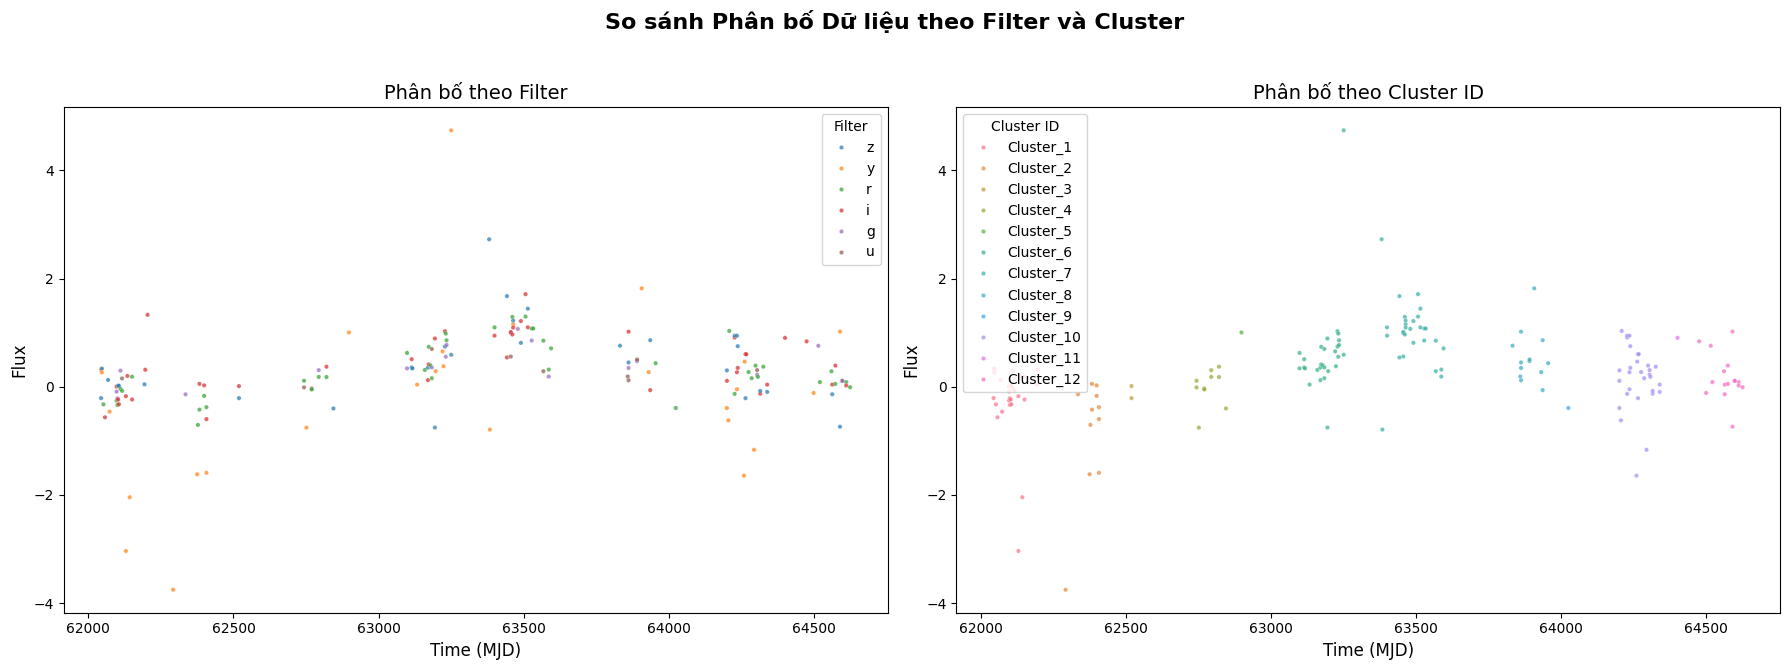

SN Ia


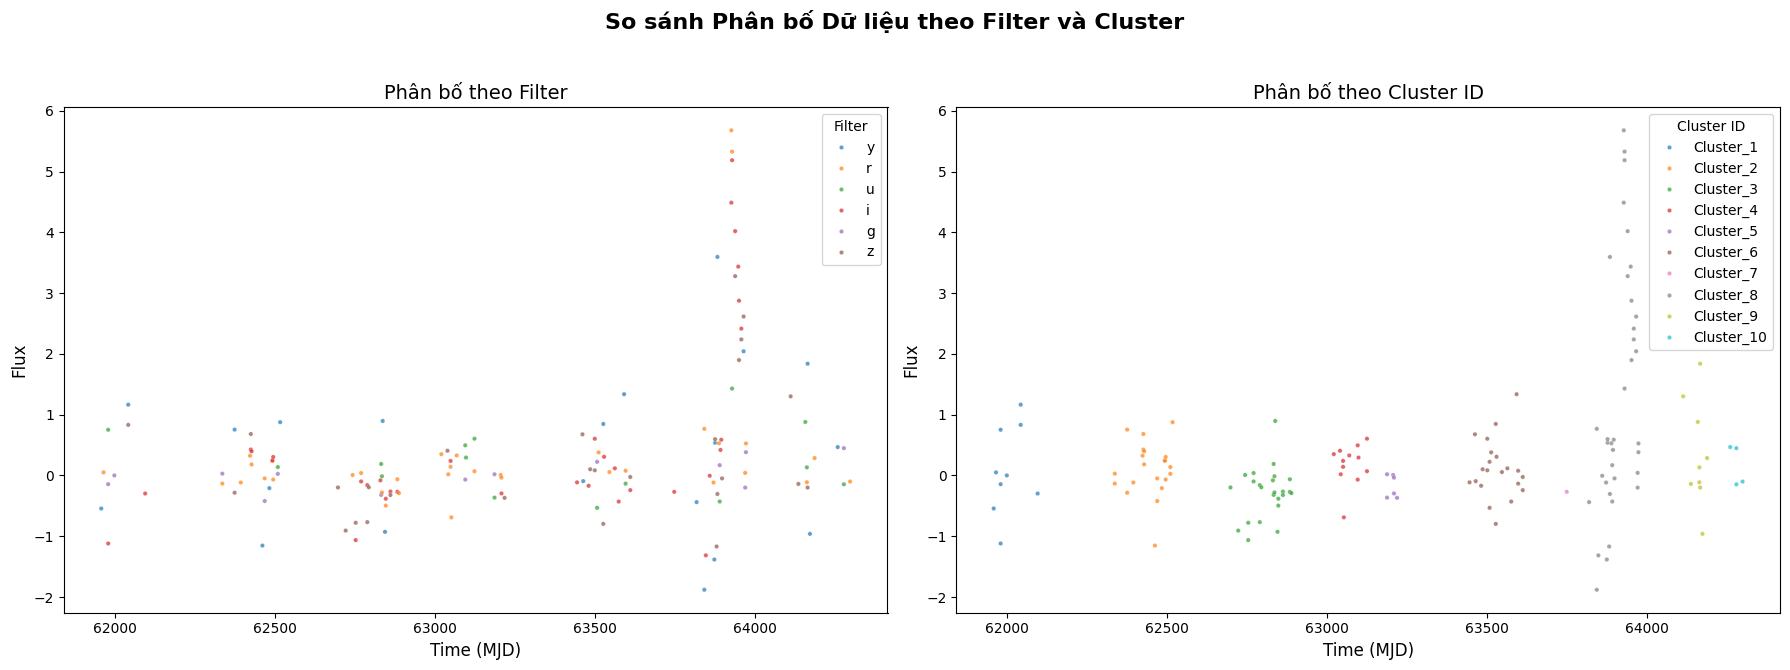

TDE


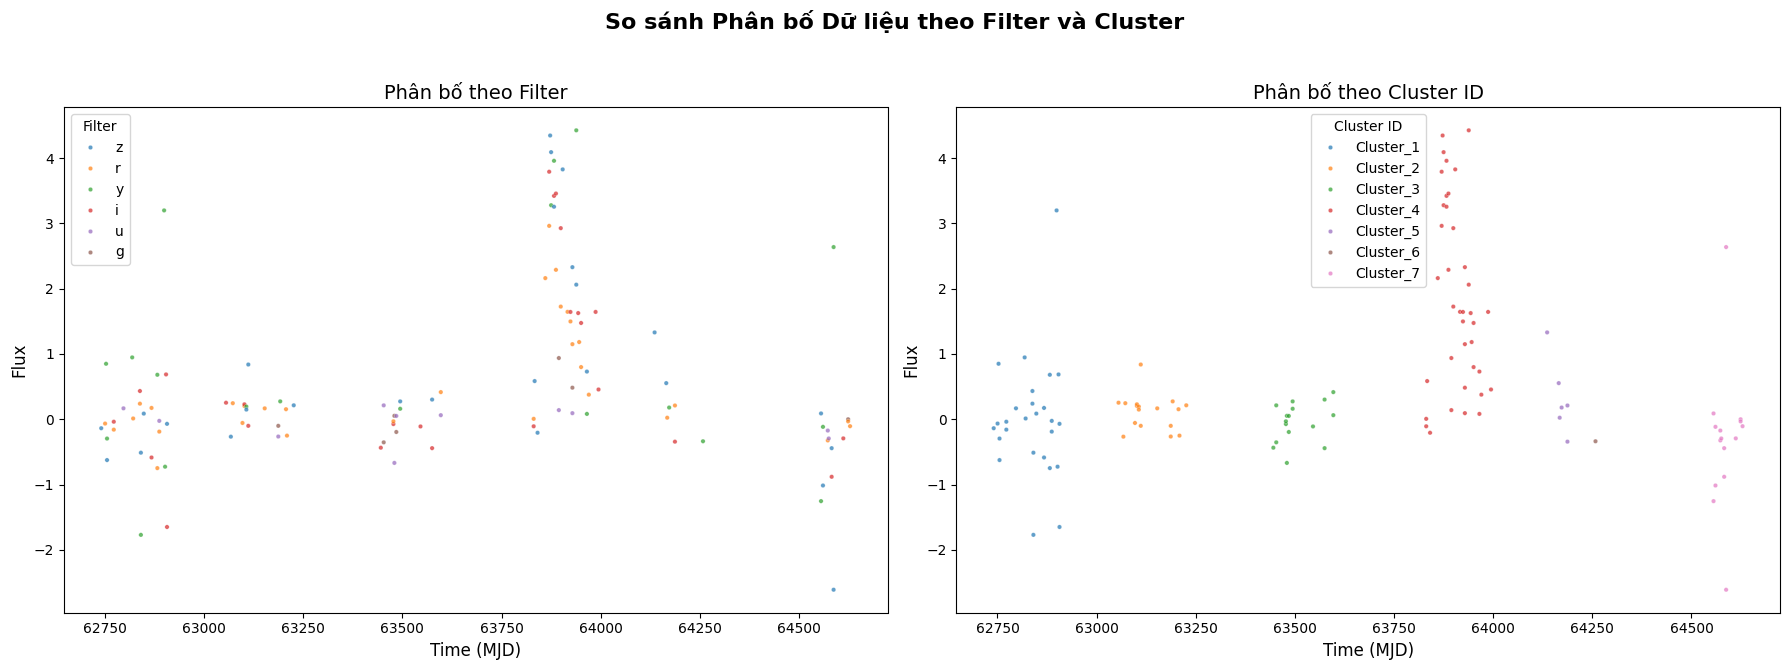

,object_id,Z,EBV,SpecType,Time (MJD),Flux,Flux_err,Filter
0,amon_imloth_luin,0.7766,0.055,TDE,63899.3404,2.927328,0.255077,i
1,amon_imloth_luin,0.7766,0.055,TDE,63923.7373,1.498455,0.101607,r
2,amon_imloth_luin,0.7766,0.055,TDE,63904.2198,3.827528,0.475724,z
3,amon_imloth_luin,0.7766,0.055,TDE,63916.4182,1.645513,0.206576,r
4,amon_imloth_luin,0.7766,0.055,TDE,63923.7373,1.643693,0.150162,i
...,...,...,...,...,...,...,...,...
114,amon_imloth_luin,0.7766,0.055,TDE,63152.7974,0.167314,0.181362,r
115,amon_imloth_luin,0.7766,0.055,TDE,63186.9530,-0.100870,0.102353,g
116,amon_imloth_luin,0.7766,0.055,TDE,63191.8324,0.274156,0.941367,y
117,amon_imloth_luin,0.7766,0.055,TDE,63206.4705,0.153985,0.130768,r


In [8]:

def random_sampling_split(df_object, required_points, max_sample):
    """
    Tạo các mẫu (splits) bằng cách lấy mẫu ngẫu nhiên (uniform) số lượng điểm 
    nhất định từ mỗi Filter (ống kính).
    
    Args:
        df_object (pd.DataFrame): DataFrame của 1 object_id, đã gộp log và split.
        points_on_each_filter (int): Số dòng/điểm cần lấy trên mỗi filter.
        max_sample (int): Số lượng splits tối đa muốn tạo ra.
        seed (int): Random seed cho việc lấy mẫu.
    
    Returns:
        list: Danh sách các DataFrame nhỏ (splits) đã được lấy mẫu ngẫu nhiên.
    """
    
    # 1. Grouping theo Filter
    grouped = df_object.groupby('Filter')
    
    # 2. Xác định margin (số lượng mẫu dư ra)
    min_group_length = grouped.size().min()
    
    # Số lượng bản ghi cần thiết cho 1 mẫu hoàn chỉnh (đủ tất cả filters)
    margin = min_group_length - required_points
    if not max_sample : max_sample = margin
    
    # 3. Xác định Số lần Lặp
    # margin + 1 là số lượng vị trí bắt đầu có thể có, tính cả vị trí cuối cùng.
    num_iterations = min(margin, max_sample) if margin > 0 else 1
    
    splits = []
    
    # 4. Lấy mẫu ngẫu nhiên các vị trí bắt đầu    
    for _ in range(num_iterations):
        all_filters_sample = []
        
        # Lấy mẫu từ mỗi group
        for filter_name, group in grouped:
            
            sample = group.sample(n=min( len(group), required_points ), 
                                random_state=None) 
            
            all_filters_sample.append(sample)
            
        # Hợp nhất các mẫu từ các filter
        split_df = pd.concat(all_filters_sample, ignore_index=True)
        splits.append(split_df)
        
    return splits

def time_based_clustering_split(df_object):
    """
    Phân tách DataFrame của một object_id thành các cluster dựa trên khoảng cách thời gian 
    lớn hơn ngưỡng: mean(time_diff) + std(time_diff).
    
    Args:
        df_object (pd.DataFrame): DataFrame của 1 object_id, đã gộp log và split.
    
    Returns:
        list: Danh sách các DataFrame cluster.
    """

    # 1. Sắp xếp theo thời gian Time (MJD)
    # Rất quan trọng: Chỉ sắp xếp df_temp, không thay đổi df_object gốc
    df_object = df_object.sort_values('Time (MJD)').reset_index(drop=True)
    
    # 2. Tính time_diff giữa các dòng liên tiếp
    time_diff = df_object['Time (MJD)'].diff()
    
    # 3. Tính Ngưỡng Phân tách (separation_line)
    # Bỏ qua NaN (dòng đầu tiên) khi tính mean và std
    mean_diff = time_diff.mean()
    std_diff = time_diff.std()
    
    # Ngưỡng phân tách
    separation_line = mean_diff + std_diff
    
    # Nếu không có đủ dữ liệu (ví dụ: chỉ 1 dòng), không thể tính toán, trả về toàn bộ
    if np.isnan(separation_line):
        return [df_object]
        
    # 4. Xác định Điểm Chia tách và Tạo Nhãn Cluster
    # Dòng đầu tiên (time_diff=NaN) được xử lý là False (không phải điểm chia tách)
    # mask: True nếu là khoảng nghỉ lớn
    is_split_point = (time_diff >= separation_line)
    is_split_point.iloc[0] = False 
    
    # Tạo Cluster ID: Tăng ID mỗi khi gặp một khoảng nghỉ lớn
    df_object['cluster_id'] = is_split_point.cumsum()
    
    # 5. Tách DataFrame thành List Cluster
    cluster_list = [group.drop(columns='cluster_id') 
                    for name, group in df_object.groupby('cluster_id')]
    
    # Ghi chú về Xử lý Đường Phân tách:
    # Logic cumsum đảm bảo dòng có time_diff > separation_line 
    # (tức là dòng *sau* khoảng nghỉ) sẽ bắt đầu cluster mới (ID tăng). 
    # Dòng liền trước đó (dòng kết thúc cluster cũ) sẽ nằm trong cluster cũ, 
    
    return cluster_list

def cluster_represent(df_object) :
    """
    Chuyển đổi danh sách các cluster (DataFrame) thành các đặc trưng thống kê 
    đại diện, được nhóm theo Filter.
    
    Args:
        cluster_list (list): Danh sách các DataFrame cluster, trả ra từ 
                             time_based_clustering_split.
    
    Returns:
        pd.DataFrame: DataFrame duy nhất, mỗi dòng là các đặc trưng 
                      thống kê của một Cluster-Filter.
    """
    
    cluster_list = time_based_clustering_split(df_object)
    all_cluster_features = []
    
    for cluster_id, cluster_df in enumerate(cluster_list):
        
        # 1. Nhóm theo Filter trong mỗi Cluster
        grouped_by_filter = cluster_df.groupby('Filter')
        
        # 2. Tính Đặc trưng Thống kê (min, max, mean)
        # Sử dụng .agg() để tính toán nhiều thống kê cùng lúc trên Flux và Flux_err
        stats = grouped_by_filter[['Flux', 'Flux_err']].agg(['mean']).reset_index()
        
        # 3. Chỉnh sửa DataFrame để tạo ra các tên cột rõ ràng
        # Ví dụ: (Flux, min) -> Flux_min
        
        # Làm phẳng cột đa cấp
        stats.columns = ['Filter'] + [f'{col[0]}_{col[1]}' for col in stats.columns.tolist()[1:]]
        
        
        # Lấy object_id (giả định object_id là cột đầu tiên của DF)
        if 'object_id' in cluster_df.columns:
            stats['object_id'] = cluster_df['object_id'].iloc[0]
            stats['SpecType'] = cluster_df['SpecType'].iloc[0]
            stats['Z'] = cluster_df['Z'].iloc[0]
            
        all_cluster_features.append(stats)
            
    # 5. Hợp nhất Cuối cùng và trả về
    if all_cluster_features:
        final_df = pd.concat(all_cluster_features, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()
    

##-- Ví dụ sử dụng --   
example = []
for SpecType, data in sample_log_raw.groupby('SpecType') :
    print(SpecType)
    plot_cluster_and_filter_distribution(time_based_clustering_split(data))
    if SpecType == 'TDE' :
        example = data
data


# 3. <a id='toc3_'></a>[Xử lý data](#toc0_)

Cơ chế:
- Tạo features bằng các hàm đã chuẩn bị
- Tách Train-Validation tách khỏi Test-set
- Huẩn luyện mô hình LightGBM dựa trên K-fold
- Đánh giá

## 3.1. <a id='toc3_1_'></a>[Tạo features](#toc0_)

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import r2_score

# --- 1. Hàm Phụ: Tính toán Features cho 1 Filter Group ---
def run_wls_and_calculate_stats(df_filter_group):
    """
    Thực hiện Hồi quy Tuyến tính có Trọng số (WLS) và tính toán 
    các chỉ số Model-Based cho một nhóm Filter.
    """
    # Đảm bảo có đủ ít nhất 2 điểm cho hồi quy và 1 điểm cho thống kê cơ bản
    if len(df_filter_group) < 2:
        return pd.Series({
            'WMean_Flux': np.nan, 
            'WStd_Flux': np.nan, 
            'WLS_Slope': np.nan, 
            'WLS_Intercept': np.nan, 
            'WLS_R2': np.nan, 
            'Reduced_Chi2': np.nan,
            'Duration': np.nan,
            'Amplitude': np.nan,
            'Count': len(df_filter_group)
        })

    # Dữ liệu
    Y = df_filter_group['Flux']
    X = df_filter_group['Time (MJD)']
    W = 1 / df_filter_group['Flux_err']**2

    # WLS cần phải có Intercept được thêm thủ công
    X_with_const = sm.add_constant(X, prepend=False)
    
    # Chuẩn hóa MJD để tránh lỗi overflow (Optional nhưng nên làm)
    mjd_min = X.min()
    X_norm = X - mjd_min
    X_norm_with_const = sm.add_constant(X_norm, prepend=False)

    # Khởi tạo và Huấn luyện WLS
    try:
        wls_model = sm.WLS(Y, X_norm_with_const, weights=W)
        wls_results = wls_model.fit()
        
        # Dự đoán cho việc tính R2
        Y_pred = wls_results.predict(X_norm_with_const)
        
        # Lấy các hệ số
        # Hệ số 0 là MJD_norm (Slope), Hệ số 1 là Const (Intercept tại MJD_norm=0)
        slope = wls_results.params.iloc[0]
        intercept = wls_results.params.iloc[1]
        r_squared = r2_score(Y, Y_pred)
        
        # --- Tính WMean Flux (sử dụng công thức WLS khi không có biến X) ---
        # Cách 1: Intercept WLS_norm (tại MJD=min(MJD))
        # Cách 2: Công thức trực tiếp
        w_mean_flux = (Y * W).sum() / W.sum()
        
        # --- Tính WStd Flux ---
        w_std_flux = np.sqrt(((Y - w_mean_flux)**2 * W).sum() / W.sum())

        # --- Tính Reduced Chi-Squared (so với WMean Flux) ---
        # Sử dụng WMean Flux làm mô hình hằng số (mu)
        chi2 = ((Y - w_mean_flux)**2 / df_filter_group['Flux_err']**2).sum()
        # DOF = N - 1 (vì ta chỉ ước tính 1 tham số: WMean)
        reduced_chi2 = chi2 / (len(df_filter_group) - 1)
        
        # --- Tính Amplitude và Duration ---
        duration = X.max() - X.min()
        amplitude = Y.max() - Y.min()
        count = len(df_filter_group)

        # Trả về các đặc trưng
        return pd.Series({
            'WMean_Flux': w_mean_flux, 
            'WStd_Flux': w_std_flux, 
            'WLS_Slope': slope, 
            'WLS_Intercept': intercept, 
            'WLS_R2': r_squared, 
            'Reduced_Chi2': reduced_chi2,
            'Duration': duration,
            'Amplitude': amplitude,
            'Count': count
        })
        
    except np.linalg.LinAlgError:
        # Xảy ra nếu ma trận X không khả nghịch (ít xảy ra)
        return pd.Series({
            'WMean_Flux': np.nan, 
            'WStd_Flux': np.nan, 
            'WLS_Slope': np.nan, 
            'WLS_Intercept': np.nan, 
            'WLS_R2': np.nan, 
            'Reduced_Chi2': np.nan,
            'Duration': np.nan,
            'Amplitude': np.nan,
            'Count': len(df_filter_group)
        })

# --- 2. Hàm Chính: Tính toán Features cho Cluster ---
def calculate_model_based_features_for_cluster(df_cluster, column_drop=[], column_metadata=['object_id', 'Z', 'SpecType', 'EBV']):
    """
    Tính toán các đặc trưng Model-Based (WLS, Chi-Squared) cho một Cluster.
    
    Args:
        df_cluster (pd.DataFrame): DataFrame của một Cluster duy nhất.
        column_drop (list): Các cột cần loại bỏ khỏi DataFrame metadata.
        column_metadata (list): Các cột metadata cần giữ lại trong kết quả cuối cùng.
        
    Returns:
        pd.DataFrame: DataFrame 1 dòng chứa các đặc trưng đã gộp theo Filter.
    """
    
    # 1. Trích xuất metadata (chỉ lấy 1 dòng vì là 1 object)
    meta_features = df_cluster[column_metadata].iloc[0].drop(labels=column_drop, errors='ignore').to_dict()
    
    # 2. Nhóm theo Filter và tính toán Model-Based Features
    grouped = df_cluster.groupby('Filter').apply(run_wls_and_calculate_stats)
    
    # 3. Thêm Ratio Count/Duration (dùng các cột đã tính)
    grouped['Count_Duration_Ratio'] = grouped['Count'] / grouped['Duration']
    
    # 4. Làm phẳng và Đặt tên cột (Pivot)
    # Tên cột mới: [Filter]_[Tên Feature]
    grouped_features = grouped.unstack().to_dict()
    
    # Xử lý các cột bị NaN sau khi unstack nếu một số Filter bị thiếu
    final_features = {}
    
    # Ví dụ: grouped_features có key là ('WMean_Flux', 'g')
    # Ta chuyển thành 'g_WMean_Flux'
    for (feature_name, filter_name), value in grouped_features.items():
        final_features[f'{filter_name}_{feature_name}'] = value
        
    # 5. Kết hợp Metadata và Features
    # Chuyển dictionary kết hợp thành DataFrame 1 dòng
    meta_features.update(final_features)
    
    return pd.DataFrame([meta_features])

In [21]:
def full_process(df_log, df_split) :
    # 0. Nhóm các SpecType thiểu số lại
    df_log['SpecType'] = df_log['SpecType'].mask(~df_log['SpecType'].isin(['AGN', 'TDE']), 'SN')
    
    # 1. Hợp nhất df
    total_df = join_DataFrame(df_log, df_split)

    # 2. extinct flux
    total_df['Flux'] = total_df.apply(
        jurassic_park, 
        axis=1, # Áp dụng trên từng hàng (row-wise)
        result_type='expand' # Mở rộng kết quả (tuple) thành các cột riêng biệt
    )

    # 2'. Drop các cột không cần thiết và nhóm lại theo object_id
    total_df = total_df.drop(['Z_err', 'split', 'EBV'], axis = 1)
    grouped_single_object = total_df.groupby('object_id')

    # 3. Tiến hành sampling
    sampled_single_object = []
    for object_id, data_raw in grouped_single_object :
        sampled_single_object.extend(
           time_based_clustering_split(data_raw)
        )

    # 3. Tạo features
    grouped_extracted = [extract_features_for_single_object(df_raw, None)
                         for df_raw in sampled_single_object]
    
    result = pd.concat(grouped_extracted, ignore_index=True)
    
    return result


sampled_training = process_and_combine_splits(
    sample_log,
    'train_full_lightcurves.csv',
    full_process
)

sampled_training.head()

,object_id,Z,SpecType,i_Flux_mean,i_Flux_min,i_Flux_max,i_Flux_std,i_Flux_skewness,i_Flux_kurtosis,i_Flux_err_mean,i_Flux_err_min,i_Flux_err_max,i_Flux_err_std,i_Flux_err_skewness,i_Flux_err_kurtosis,r_Flux_mean,r_Flux_min,r_Flux_max,r_Flux_std,r_Flux_skewness,r_Flux_kurtosis,r_Flux_err_mean,r_Flux_err_min,r_Flux_err_max,r_Flux_err_std,r_Flux_err_skewness,r_Flux_err_kurtosis,u_Flux_mean,u_Flux_min,u_Flux_max,u_Flux_std,u_Flux_skewness,u_Flux_kurtosis,u_Flux_err_mean,u_Flux_err_min,u_Flux_err_max,u_Flux_err_std,u_Flux_err_skewness,u_Flux_err_kurtosis,y_Flux_mean,y_Flux_min,y_Flux_max,y_Flux_std,y_Flux_skewness,y_Flux_kurtosis,y_Flux_err_mean,y_Flux_err_min,y_Flux_err_max,y_Flux_err_std,y_Flux_err_skewness,y_Flux_err_kurtosis,z_Flux_mean,z_Flux_min,z_Flux_max,z_Flux_std,z_Flux_skewness,z_Flux_kurtosis,z_Flux_err_mean,z_Flux_err_min,z_Flux_err_max,z_Flux_err_std,z_Flux_err_skewness,z_Flux_err_kurtosis,g_Flux_mean,g_Flux_min,g_Flux_max,g_Flux_err_mean,g_Flux_err_min,g_Flux_err_max,g_Flux_std,g_Flux_skewness,g_Flux_kurtosis,g_Flux_err_std,g_Flux_err_skewness,g_Flux_err_kurtosis
0,amon_imloth_luin,0.7766,TDE,-0.230831,-1.650098,0.686760,0.930030,-0.636388,-0.920881,0.351467,0.181669,0.555731,0.181953,0.318299,-1.784177,-0.105484,-0.748057,0.238712,0.325186,-1.056929e+00,0.318272,0.170122,0.120646,0.200984,0.030916,-4.119087e-01,-1.201755,0.071502,-0.024836,0.167840,0.136243,0.00000,-2.000000,0.330529,0.285974,0.375085,0.063011,-1.762061e-15,-2.000000,0.412114,-1.770718,3.199092,1.574810,4.458173e-01,-0.309948,1.125457,0.858665,1.685058,0.314690,0.937206,-0.665947,-0.251626,-0.625070,0.086532,0.303224,-2.370137e-01,-1.580648,0.477743,0.279658,0.636733,0.136881,-3.767477e-01,-1.012369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,amon_imloth_luin,0.7766,TDE,0.127330,-0.100671,0.253379,0.197822,-0.695323,-1.500000,0.352641,0.306722,0.393424,0.043579,-0.213489,-1.500000,0.077253,-0.250834,0.246171,0.191869,-9.212550e-01,-0.684084,0.157015,0.111290,0.206434,0.034171,1.173998e-01,-1.035114,-0.264481,-0.264481,-0.264481,NaN,NaN,NaN,0.273757,0.273757,0.273757,NaN,NaN,NaN,0.234181,0.194206,0.274156,0.056533,-1.060775e-15,-2.000000,1.109860,0.941367,1.278353,0.238285,0.000000,-2.000000,0.233402,-0.266979,0.838408,0.456091,3.875945e-01,-0.979459,0.515698,0.381100,0.578621,0.091173,-1.049130e+00,-0.752074,-0.100870,-0.100870,-0.100870,0.102353,0.102353,0.102353,NaN,NaN,NaN,NaN,NaN,NaN
2,amon_imloth_luin,0.7766,TDE,-0.265429,-0.442487,-0.073422,0.201201,0.015880,-1.977425,0.224322,0.194968,0.244326,0.021117,-0.679921,-0.969745,0.192345,-0.031234,0.415924,0.316188,7.760834e-17,-2.000000,0.139829,0.114895,0.164763,0.035263,0.000000e+00,-2.000000,-0.085486,-0.668667,0.213214,0.395750,-1.03025,-0.744999,0.353696,0.257905,0.485282,0.095632,6.036157e-01,-0.955033,0.160675,0.160675,0.160675,NaN,NaN,NaN,1.134329,1.134329,1.134329,NaN,NaN,NaN,0.287560,0.273679,0.301441,0.019631,5.937915e-15,-2.000000,0.430152,0.380905,0.479399,0.069646,1.588580e-15,-2.000000,-0.165235,-0.353279,0.052465,0.106008,0.089473,0.131092,0.204491,2.608191e-01,-1.5,0.022087,0.604561,-1.5
3,amon_imloth_luin,0.7766,TDE,2.033567,-0.107380,3.791350,1.320628,-0.121660,-1.158077,0.285351,0.150162,0.560407,0.152775,1.055069,-0.413439,1.436163,0.006330,2.962307,0.862185,2.945892e-02,-0.639924,0.143427,0.101607,0.206576,0.032546,5.448162e-01,-0.788534,0.116800,0.093447,0.140152,0.033025,0.00000,-2.000000,0.259581,0.256813,0.262349,0.003915,0.000000e+00,-2.000000,2.936456,0.081964,4.426008,1.960423,-9.626765e-01,-0.820840,1.311946,0.900191,1.979239,0.487561,0.657470,-1.142735,2.335578,-0.206770,4.346346,1.672462,-2.355742e-01,-1.394380,0.571274,0.369230,1.407859,0.326048,2.152766e+00,3.147000,0.710529,0.483281,0.937778,0.096067,0.094294,0.097840,0.321378,-3.695449e-16,-2.0,0.002507,0.000000,-2.0
4,amon_imloth_luin,0.7766,TDE,-0.343386,-0.343386,-0.343386,NaN,NaN,NaN,0.215752,0.215752,0.215752,NaN,NaN,NaN,0.117174,0.023416,0.210932,0.132593,0.000000e+00,-2.000000,0.172509,0.157813,0.187

## 3.2. <a id='toc3_2_'></a>[Chia train-test](#toc0_)

In [10]:
from sklearn.model_selection import train_test_split

# # 1. Chuẩn bị Dữ liệu
train_log
train_log['SpecType'] = train_log['SpecType'].mask(~train_log['SpecType'].isin(['AGN', 'TDE']), 'SN')
train_label = train_log['SpecType']

# 2. Phân chia Stratify (giữ nguyên tỉ lệ các nhãn)
train_cv_log, train_test_log, _, _ = train_test_split(
    train_log, 
    train_label, 
    test_size=0.2, 
    stratify=train_label,  # <-- SỬ DỤNG STRATIFY
    random_state=None
)

# 3. Features Extraction & Augementation cho train_cv_log
train_cv_extracted = process_and_combine_splits(
    train_cv_log,
    'train_full_lightcurves.csv',
    full_process
).set_index('object_id')

X_cv = train_cv_extracted.drop(columns=['SpecType']) # Đặc trưng
y_cv = train_cv_extracted['SpecType']                # Nhãn mục tiêu


f'Training set: {len(y_cv)}'


'Training set: 22101'

In [11]:
# 4. Features Extraction & Augementation cho test_cv_log

train_test_extracted = process_and_combine_splits(
    train_test_log,
    'train_full_lightcurves.csv',
    full_process
).set_index('object_id')

X_test = train_test_extracted.drop(columns=['SpecType'])
y_test = train_test_extracted['SpecType']

f'Testing set: {len(y_test)}'

'Testing set: 5467'

## 3.3. <a id='toc3_3_'></a>[Điều chỉnh nhãn](#toc0_)

In [12]:
# Thôi bỏ không dùng nữa. Định soften nhãn, nhưng model không nhận định dạng kiểu vậy

from sklearn.preprocessing import OneHotEncoder


# Chuẩn bị nhãn y_ohe_arrray cho soft-max
# ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# y_ohe_array = ohe.fit_transform(train_label.values.reshape(-1, 1))
# y_cv_ohe = ohe.fit_transform(y_cv.values.reshape(-1, 1))
# CLASS_NAMES = ohe.categories_[0]

# for further label modification
# y_soft_label = y_ohe_array.copy()

CLASS_NAMES = train_label.unique()
CLASS_NAMES

array(['AGN', 'SN', 'TDE'], dtype=object)

In [13]:
from sklearn.utils.class_weight import compute_class_weight


# Gắn trọng số để coi trọng hơn nhãn TDE (theo proportion)
class_weights_dict = compute_class_weight(
    class_weight='balanced', 
    classes=CLASS_NAMES, 
    y=train_label
)

# Chuyển thành Dictionary để dễ tra cứu và boost
weights_map_init = dict(zip(CLASS_NAMES, class_weights_dict))
weights_map_boosted = weights_map_init.copy()
weights_map_boosted['TDE'] *= 20
class_weights_dict_boosted = weights_map_boosted.values()

weights_map_boosted

{'AGN': np.float64(0.5679357969391564),
 'SN': np.float64(0.9146378118425007),
 'TDE': np.float64(137.07207207207207)}

# 4. <a id='toc4_'></a>[Huấn luyện mô hình](#toc0_)

## 4.1. <a id='toc4_1_'></a>[Setup hyper-parameters](#toc0_)

In [14]:
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 5

skf = StratifiedKFold(
    n_splits = N_SPLITS, 
    shuffle = True, 
    random_state = None)

# Tham số cơ bản cho LightGBM
lgb_params = {
    'objective': 'multiclass',          # Phân loại đa lớp
    'num_class': len(CLASS_NAMES),      # Số lượng lớp (3: AGN, SN, TDE)
    'metric': 'multi_logloss',          # Log Loss là metric tiêu chuẩn
    'boosting_type': 'gbdt',
    'n_estimators': 3000,               # Số lượng cây tối đa
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': None,
    'n_jobs': -1,
    'verbose': -1,                      # Tắt log
    
    # Xử lý mất cân bằng: Cân bằng trọng số lớp (class weights)
    'is_unbalance': False, # Nếu bạn đã dùng class_weight trong tham số fit, hãy đặt False
    'class_weight': weights_map_boosted
}

## 4.2. <a id='toc4_2_'></a>[Huấn luyện (fit)](#toc0_)

In [15]:
import lightgbm as lgb
from sklearn.metrics import log_loss, accuracy_score

models_fold = []

# Out of Fold - Tái dự đoán trên toàn bộ Cross-Validation để ước tính mức hiệu quả của mô hình
oof_proba = np.zeros((len(y_cv), lgb_params['num_class']))
oof_predictions = pd.Series(index=y_cv.index, dtype='object')


for fold, (train_index, val_index) in enumerate(skf.split(X_cv, y_cv)):
    print(f"Fold {fold+1}/{N_SPLITS} | Train Size: {len(train_index)} | Val Size: {len(val_index)}")
    
    X_train, X_val = X_cv.iloc[train_index], X_cv.iloc[val_index]
    y_train, y_val = y_cv.iloc[train_index], y_cv.iloc[val_index]

    # 1. Khởi tạo và Huấn luyện Mô hình
    model = lgb.LGBMClassifier(**lgb_params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)], # Ngừng sớm
    )
    
    # 3. Dự đoán trên tập Validation
    val_proba = model.predict_proba(X_val)
    val_predictions = [CLASS_NAMES[i] for i in np.argmax(val_proba, axis=1)]
    
    # 4. Đánh giá
    score = log_loss(y_val, val_proba)
    accuracy = accuracy_score(y_val, val_predictions)
    print(f">LogLoss: {score:.2f} | Accuracy: {accuracy:.2f}")
    score_prediction(y_val, val_predictions, CLASS_NAMES, 'TDE')

    # 5. Lưu thông tin cần thiết
    oof_proba[val_index] = val_proba
    oof_predictions.iloc[val_index] = val_predictions
    models_fold.append(model)

Fold 1/5 | Train Size: 17680 | Val Size: 4421
>LogLoss: 0.50 | Accuracy: 0.81
> AGN accuracy: 1084/1225  ~ 88.49%
> SN accuracy: 661/748  ~ 88.37%
> TDE accuracy: 27/100  ~ 27.00%
	>>> F1-score: 0.28

Fold 2/5 | Train Size: 17681 | Val Size: 4420
>LogLoss: 0.48 | Accuracy: 0.81
> AGN accuracy: 1058/1179  ~ 89.74%
> SN accuracy: 625/737  ~ 84.80%
> TDE accuracy: 23/99  ~ 23.23%
	>>> F1-score: 0.24

Fold 3/5 | Train Size: 17681 | Val Size: 4420
>LogLoss: 0.52 | Accuracy: 0.81
> AGN accuracy: 1094/1224  ~ 89.38%
> SN accuracy: 658/767  ~ 85.79%
> TDE accuracy: 27/103  ~ 26.21%
	>>> F1-score: 0.27

Fold 4/5 | Train Size: 17681 | Val Size: 4420
>LogLoss: 0.48 | Accuracy: 0.81
> AGN accuracy: 1084/1213  ~ 89.37%
> SN accuracy: 658/744  ~ 88.44%
> TDE accuracy: 29/105  ~ 27.62%
	>>> F1-score: 0.28

Fold 5/5 | Train Size: 17681 | Val Size: 4420
>LogLoss: 0.50 | Accuracy: 0.82
> AGN accuracy: 1092/1213  ~ 90.02%
> SN accuracy: 623/731  ~ 85.23%
> TDE accuracy: 20/97  ~ 20.62%
	>>> F1-score: 0.2

## 4.3. <a id='toc4_3_'></a>[Dự đoán trên tập test](#toc0_)

In [16]:
feature_important = pd.DataFrame({
    'Features' : X_cv.columns
})

test_proba = np.zeros((len(X_test), lgb_params['num_class']))

for index, model in enumerate(models_fold):
    y_proba = model.predict_proba(X_test)
    y_prediction = [CLASS_NAMES[i] for i in np.argmax(y_proba, axis=1)]
    
    score_prediction(y_test, y_prediction, CLASS_NAMES, 'TDE')
    test_proba += y_proba / N_SPLITS

    feature_important[f'Model No.{index}'] = model.feature_importances_

test_predictions = pd.Series([CLASS_NAMES[i] for i in np.argmax(test_proba, axis=1)], index=y_test.index)
score_prediction(y_test, test_predictions, CLASS_NAMES, 'TDE')

feature_important = feature_important.set_index('Features')
feature_important['mean'] = feature_important.mean(axis=1)

> AGN accuracy: 325/357  ~ 91.04%
> SN accuracy: 204/222  ~ 91.89%
> TDE accuracy: 0/30  ~ 0.00%
	>>> F1-score: 0.00

> AGN accuracy: 334/357  ~ 93.56%
> SN accuracy: 205/222  ~ 92.34%
> TDE accuracy: 0/30  ~ 0.00%
	>>> F1-score: 0.00

> AGN accuracy: 328/357  ~ 91.88%
> SN accuracy: 199/222  ~ 89.64%
> TDE accuracy: 0/30  ~ 0.00%
	>>> F1-score: 0.00

> AGN accuracy: 329/357  ~ 92.16%
> SN accuracy: 196/222  ~ 88.29%
> TDE accuracy: 0/30  ~ 0.00%
	>>> F1-score: 0.00

> AGN accuracy: 332/357  ~ 93.00%
> SN accuracy: 207/222  ~ 93.24%
> TDE accuracy: 0/30  ~ 0.00%
	>>> F1-score: 0.00

> AGN accuracy: 329/357  ~ 92.16%
> SN accuracy: 204/222  ~ 91.89%
> TDE accuracy: 0/30  ~ 0.00%
	>>> F1-score: 0.00



In [17]:
feature_important.sort_values('mean', ascending=False)

,Model No.0,Model No.1,Model No.2,Model No.3,Model No.4,mean
Features,,,,,,
Z,36065,36778,37025,37161,38409,37087.6
r_Flux_mean,6088,6722,6767,6660,6930,6633.4
z_Flux_err_max,7325,6293,6612,6591,6202,6604.6
z_Flux_min,6248,6315,6668,6693,6396,6464.0
r_Flux_max,5810,6402,6520,6367,6510,6321.8
...,...,...,...,...,...,...
y_Flux_err_kurtosis,1045,853,983,919,1266,1013.2
g_Flux_kurtosis,738,508,577,638,643,620.8
g_Flux_err_kurtosis,542,596,446,503,604,538.2


## 4.4. <a id='toc4_4_'></a>[Đánh giá](#toc0_)

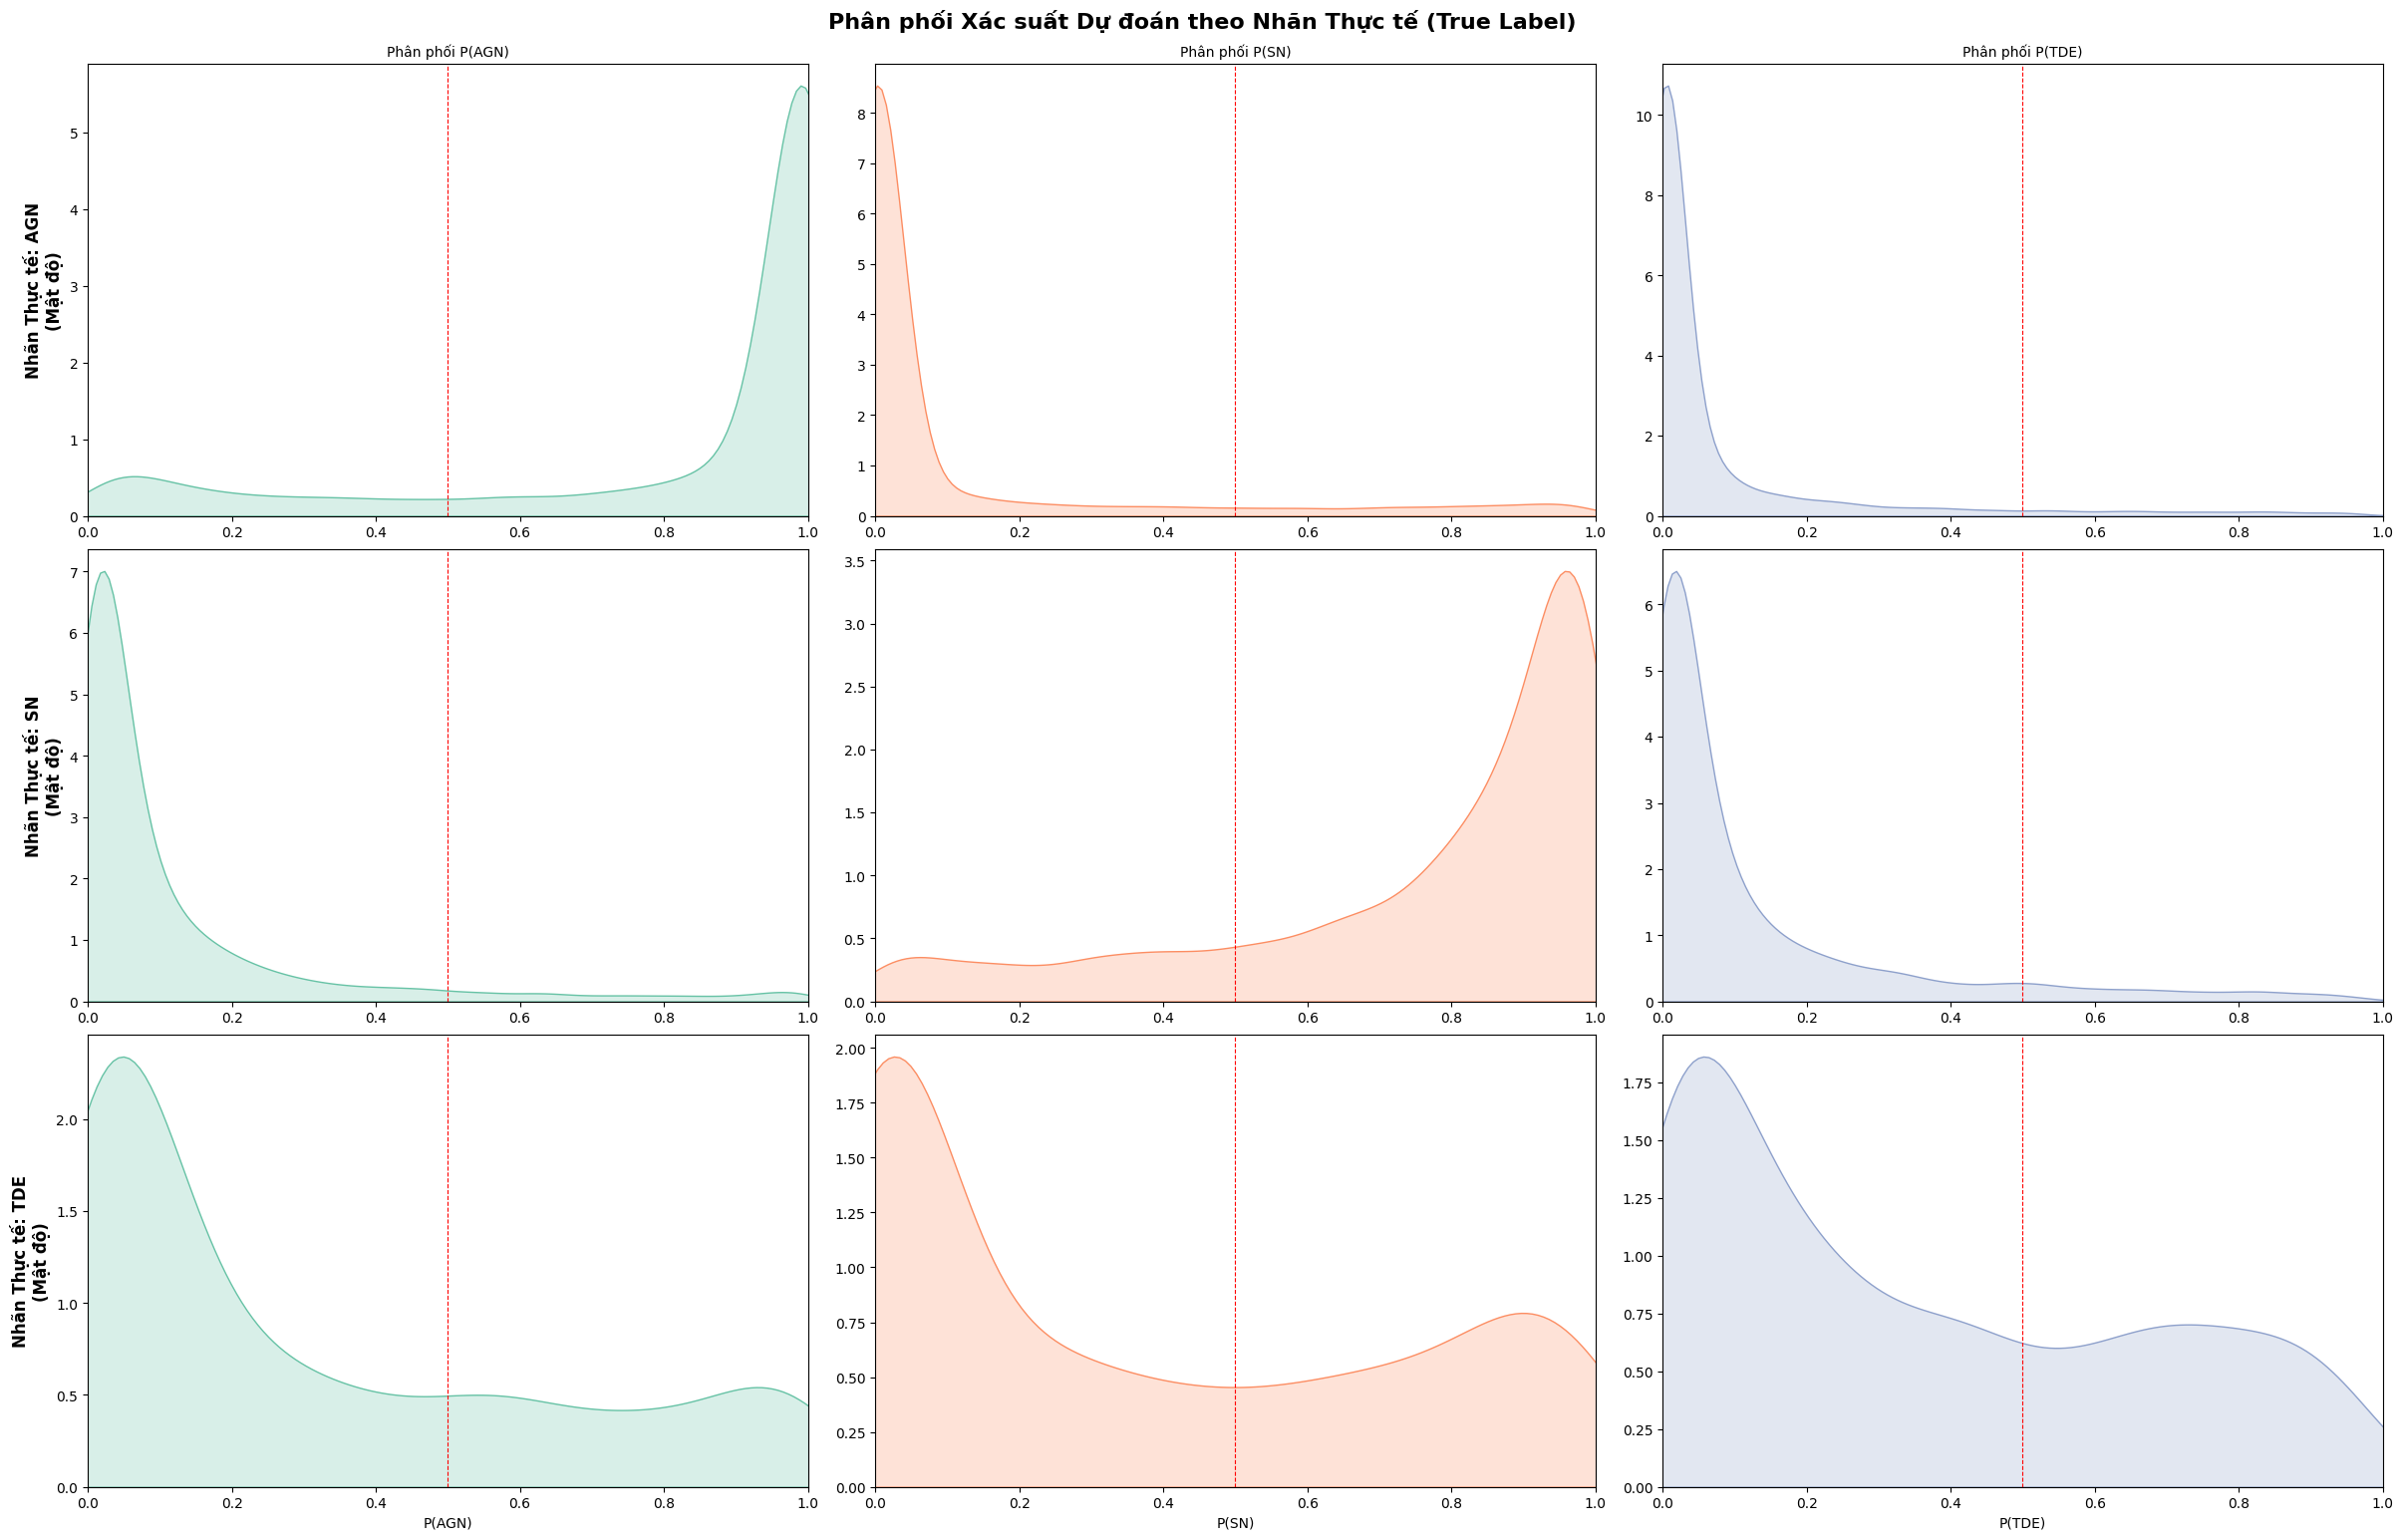

In [18]:
dist = plot_probability_distributions(oof_proba, y_cv, CLASS_NAMES)

In [19]:
dist[(dist['True Label'] == 'TDE')].head(5)

,AGN,SN,TDE,True Label
object_id,,,,
amon_imloth_luin,0.938631,0.003589,0.057780,TDE
amon_imloth_luin,0.225240,0.451467,0.323293,TDE
amon_imloth_luin,0.804938,0.065978,0.129083,TDE
amon_imloth_luin,0.319504,0.535869,0.144627,TDE
amon_imloth_luin,0.366257,0.188360,0.445383,TDE


In [20]:
ab = pd.DataFrame({
    'prediction' : oof_predictions.values,
    'label' : y_cv.values
}, index=y_cv.index)

print(len(ab[ (ab['label'] == 'TDE') & (ab['prediction'] == 'SN') ]))
print(len(ab[ (ab['label'] == 'TDE') & (ab['prediction'] == 'AGN') ]))
print(len(ab[ (ab['label'] == 'TDE') & (ab['prediction'] == 'TDE') ]))

ab[ (ab['label'] == 'TDE')].head(5)

407
325
373


,prediction,label
object_id,,
amon_imloth_luin,AGN,TDE
amon_imloth_luin,SN,TDE
amon_imloth_luin,AGN,TDE
amon_imloth_luin,SN,TDE
amon_imloth_luin,TDE,TDE


# 5. <a id='toc5_'></a>[Xuất](#toc0_)